In [2]:
%matplotlib inline


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import xbout
import scipy
import xhermes

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

# import gridtools.solps_python_scripts.setup
# from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.solps_pp import *
from code_comparison.viewer_2d import *

import general.plotstyle


from gridtools.solps_python_scripts.read_ft46 import read_ft46
from gridtools.solps_python_scripts.plot_solps import plot_2d

%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

SOLEDGE could not be imported
Viewer_2D: SOLEDGE functions not found
Done


## Read Hermes-3

In [3]:
db = CaseDB(
    case_dir = r"C:\Users\Mike\OneDrive\Project\collab\tech\cases",
    grid_dir = r"C:\Users\Mike\OneDrive\Project\collab\tech\grid"
)

toload = [ 

    dict(name="Fcx on", id="m7f-2x_tanh_25ms", unnormalise_geom = True, use_xhermes = True, squash = True), 
    dict(name="Fcx off", id="m8bb-noFcx_7pcC_tanh_25ms", unnormalise_geom = True, use_xhermes = True, squash = True), 
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)
    cs[case["name"]].extract_2d_tokamak_geometry()


- Reading case m7f-2x_tanh_25ms
-----------------------
- Looking for squash file
- Squash file found. squash date 03/01/2025, 11:42:28, dmp file date 02/27/2025, 11:11:48

Unnormalising with xHermes
- Reading case m8bb-noFcx_7pcC_tanh_25ms
-----------------------
- Looking for squash file
- Squash file found. squash date 03/03/2025, 11:29:25, dmp file date 03/03/2025, 10:04:25

Unnormalising with xHermes


In [4]:
hr = dict()
for name in cs.keys(): 
    print(name)
    hr[name] = Hermesdata()
    ds = cs[name].ds
    if "t" in ds.dims: ds = ds.isel(t=-1)
    hr[name].read_case(ds)

    
    # ds = ds.extract_2d_tokamak_geometry()
    # ds = calculate_radial_fluxes(ds, new_afn = True)
    # ds = calculate_target_fluxes(ds)
    # ds = reverse_pfr_fluxes(ds)

Fcx on
Fcx off


## Read SOLPS

In [5]:
balance_paths = {
    "base" : r"C:\Users\Mike\OneDrive\Project\lot2_2d\Moulton MAST-U SOLPS runs\45456-Dec1523-seq-23\puff=1.5e21_pump=0.001_nodrifts_bcmom2_parmvsa2_redoutpfrtrans",
}
sp = dict()
store_slc = dict()

for name in balance_paths:
    store_slc[name] = SOLPScase(balance_paths[name])
    store_slc[name].get_species()
    store_slc[name].get_impurity_stats("C", all_states = True)
    
    sp[name] = SOLPSdata()
    sp[name].read_from_case(balance_paths[name])

Saving all states
Added total radiation, density and fraction for C


# Convergence

## Profiles

C:\Users\Mike\AppData\Local\Temp\ipykernel_12224\2646662622.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [plt.cm.get_cmap("plasma", tres)(x) for x in range(tres)]
c:\Users\Mike\OneDrive\Project\python-packages\sdtools\hermes3\plotting.py:756: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if "t" in  cases[name].dims.keys():


76 106
76 106
76 106
76 106
76 106
76 106
76 106
76 106
76 106
76 106


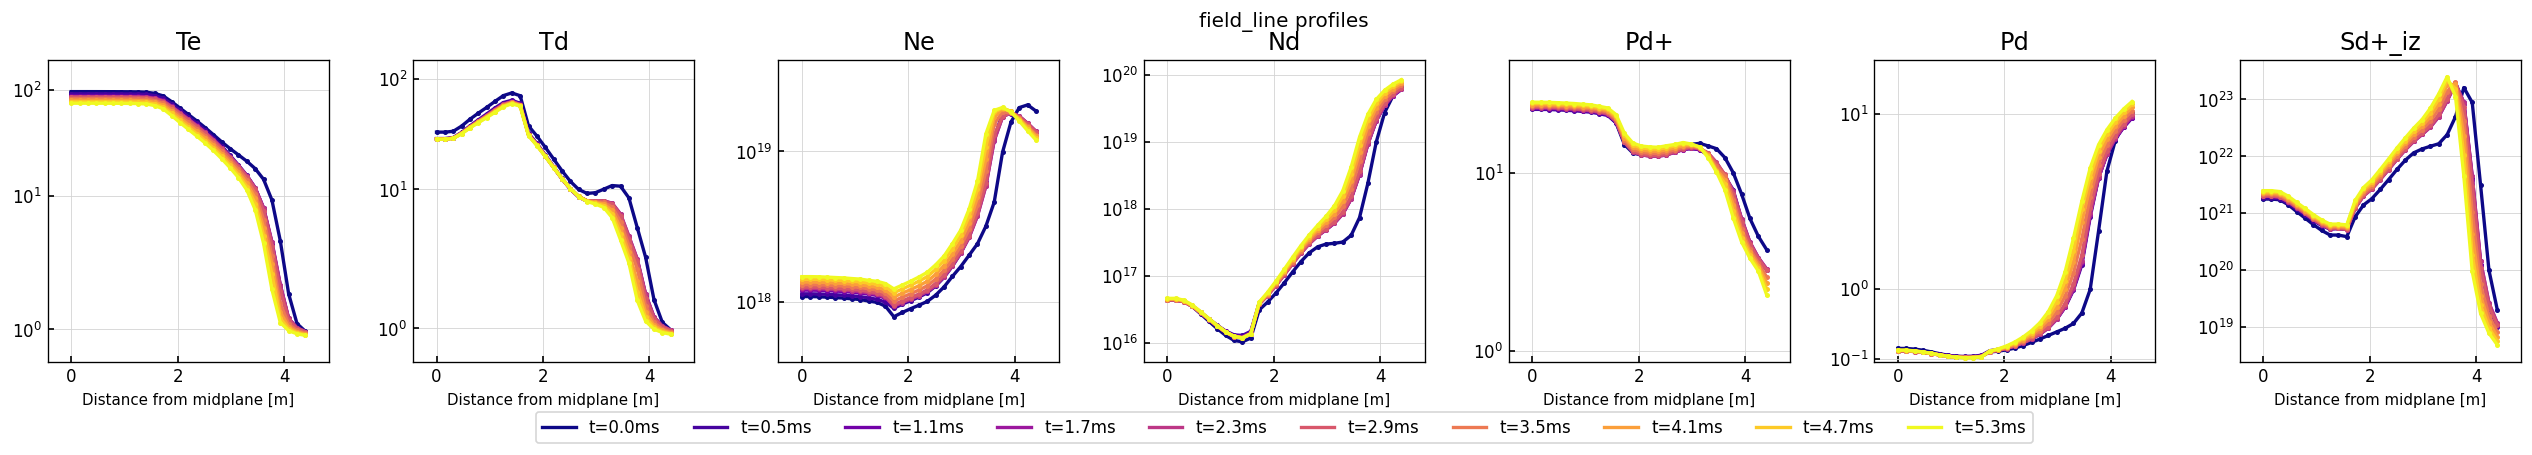

In [5]:
ds = cs["next-base"].ds

tlen = len(ds.coords["t"])
tres = 10
ts = np.linspace(0, tlen-1, tres, dtype = int)
colors = [plt.cm.get_cmap("plasma", tres)(x) for x in range(tres)]

toplot = {}
for t in ts:
    toplot[f"t={t/10}ms"] = ds.isel(t=t)
    
lineplot(
        toplot,
        clean_guards = True,
        params = ["Te", "Td", "Ne", "Nd", "Pd+", "Pd", "Sd+_iz"],
        # params = ["dv"],
        # regions = ["omp", "outer_lower", "field_line"],
        regions = ["field_line"],
        colors = colors,
    )

In [6]:
cs.keys()

dict_keys(['Fcx on', 'Fcx off'])

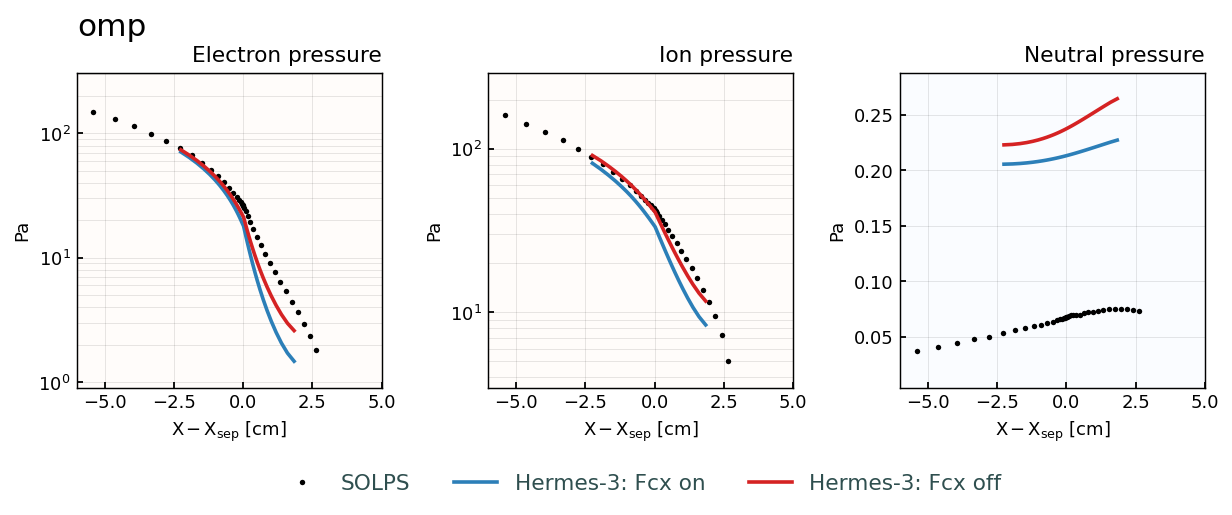

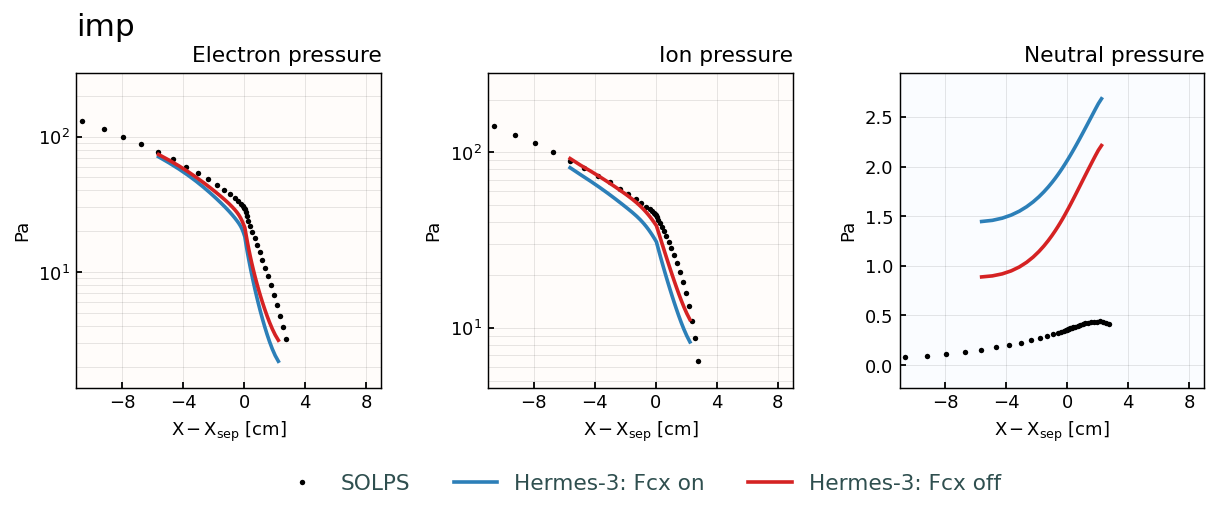

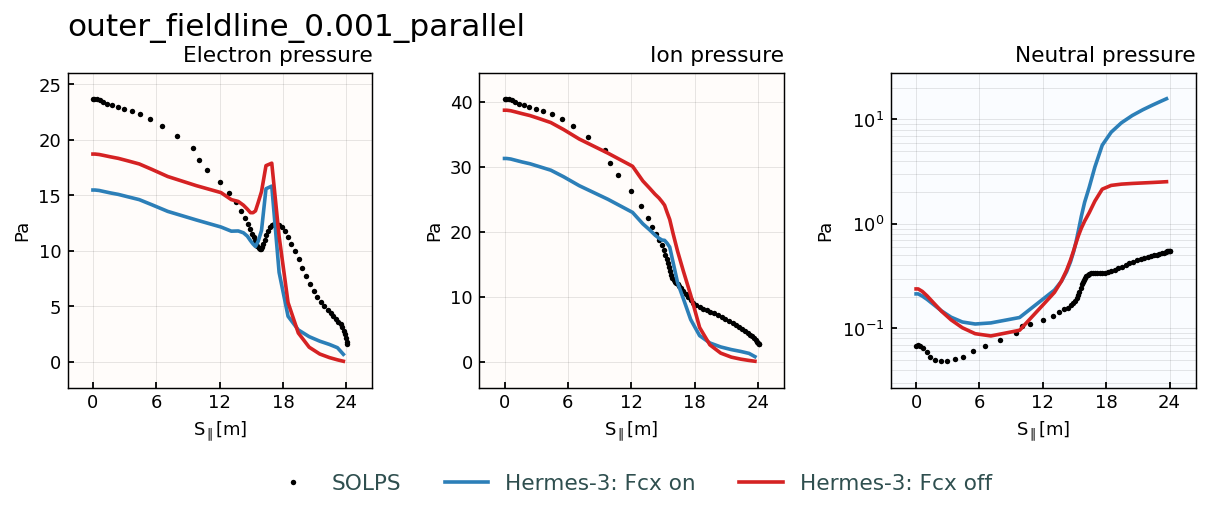

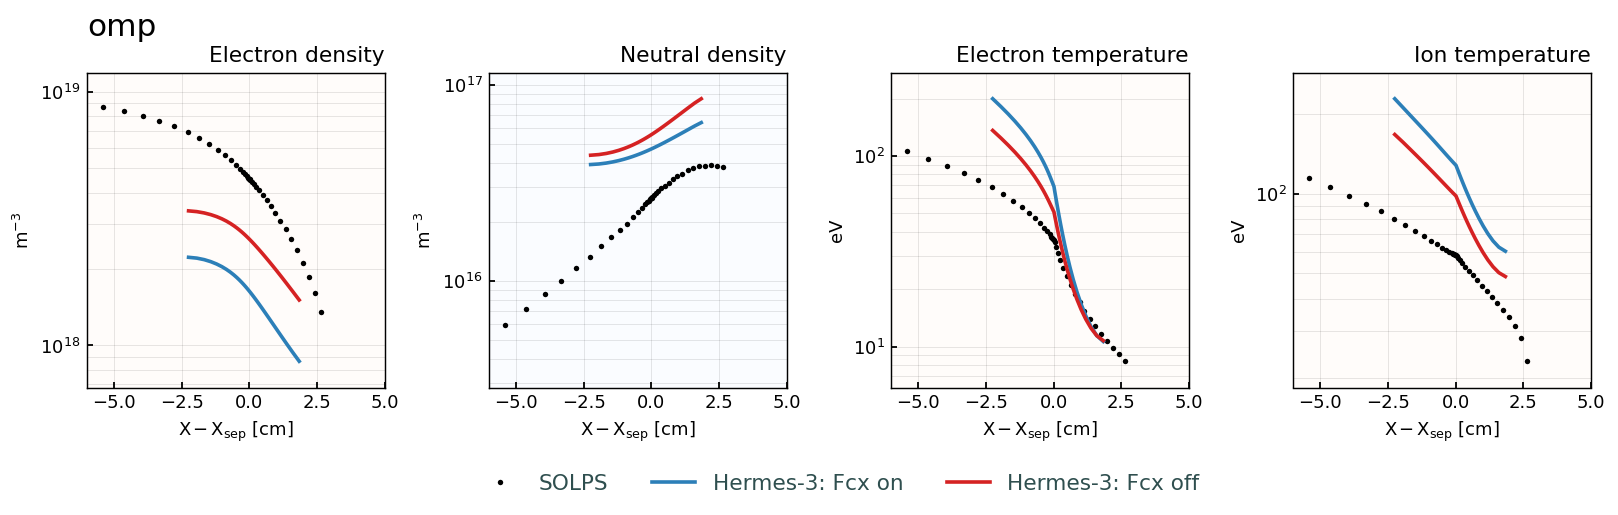

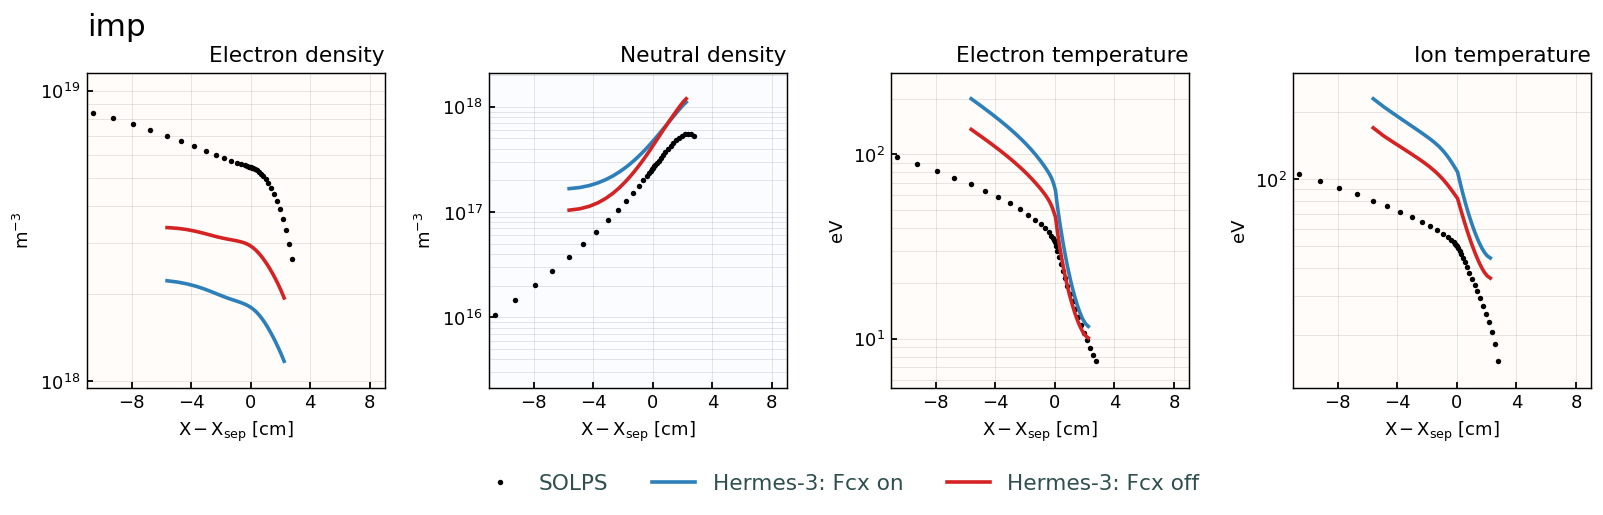

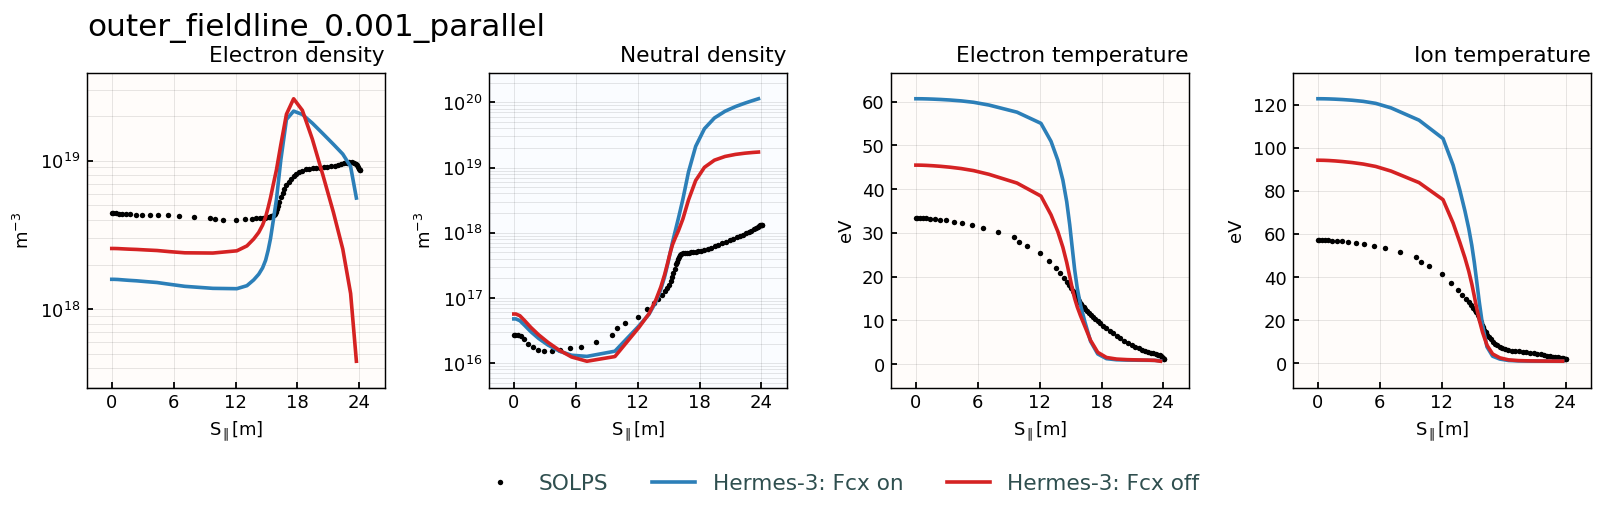

In [8]:
%matplotlib inline
plt.close("all")

params1 = ["Pe", "Pd+", "Pa"]
params2= ["Ne", "Na", "Te", "Td+"]
# params2= ["Ne", "Te"]

for params in [params1, params2]:

    lineplot_compare(
        cases = { 
        "SOLPS" : dict(data=sp["base"], color="black"),
        # r"Hermes-3: Baseline 1 (basis for 1D)" : dict(data=hr['fit_albedo'], color = "teal"),
        # r"Hermes-3: Fcx=off" : dict(data=hr['fit_albedo_noFcx'], color = "darkorange"),
        r"Hermes-3: Fcx on" : dict(data=hr['Fcx on'], color = "#2C7FB8"),
        r"Hermes-3: Fcx off" : dict(data=hr['Fcx off'], color = "#D52223"),
        # r"Hermes-3: div. pump: 3.0e21s-1" : dict(data=hr['Divertor pump: 3.0e21s-1'], color = "skyblue"),
         
        # r"Hermes-3: Tune puff" : dict(data=hr['fit_puff'], color = "darkorange"),
        },
        regions = ["omp", "imp", "outer_fieldline_0.001_parallel"],  
        # regions = ["outer_fieldline_0.001_parallel"],
        # regions = ["outer_lower"],
        params = params,
        mode = "log",
        dpi = 100,
        lw = 2,
        legend_nrows =1,
        combine_molecules = False
    )

## Front tracking

In [5]:
for name in cs:
# for name in ["addc_4x"]:
    cs[name].ds.hermesm.get_front_position(more_fronts = False)


c:\Users\Mike\OneDrive\Project\python-packages\sdtools\hermes3\front_tracking.py:20: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  df["t"] = ds["t"]
c:\Users\Mike\OneDrive\Project\python-packages\sdtools\hermes3\front_tracking.py:47: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  
c:\Users\Mike\OneDrive\Project\python-packages\sdtools\hermes3\front_tracking.py:20: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `

In [40]:
if "t" not in ds.dims:
        raise Exception("Dataset must contain more than one timestep")
    
df = pd.DataFrame()
df.index = range(len(ds["t"]))
df["t"] = ds["t"]

for sepadd in range(7):
    fl = ds.hermesm.select_custom_sol_ring("outer_lower", sepadd = sepadd).squeeze()
    dist = np.cumsum(fl["dl"]).values
    pardist = np.cumsum(fl["dl"] * fl["Bxy"] / fl["Bpxy"])
    dist_from_target = dist[-1] - dist


    def find_crossing_vectorized(dist, data, threshold):
        """Vectorized crossing finder for all timesteps at once, matching original loop."""
        num_timesteps = data.shape[0]
        crossing_locations = np.full(num_timesteps, np.nan)  # Initialize result array

        for i in range(num_timesteps):
            temp_profile = data[i, :]  # Extract temperature at time t

            # Find all crossing indices
            crossings = np.where(np.diff(np.signbit(temp_profile - threshold)))[0]

            if crossings.size == 0:
                continue  # No crossings found

            final_crossing = crossings[-1]  # Use the last crossing (like original loop)

            # Linear interpolation for smooth position
            t1, t2 = dist[final_crossing], dist[final_crossing + 1]
            data1, data2 = temp_profile[final_crossing], temp_profile[final_crossing + 1]

            crossing_locations[i] = t1 + (threshold - data1) * (t2 - t1) / (data2 - data1)

        return crossing_locations

# Apply vectorized function over time dimension
# pol_5eV = find_crossing_vectorized(dist, fl["Te"].values, 5)
    df[sepadd] = find_crossing_vectorized(pardist, fl["Te"].values, 5)

# pol_5eV = []
# par_5eV = []

# for t in range(ds.dims["t"]):
#     timeslice = fl.isel(t=t)
#     pol_5eV.append(find_crossing(dist, timeslice["Te"].values, 5))
#     par_5eV.append(find_crossing(pardist, timeslice["Te"].values, 5))
    
# plt.plot(ds["t"], par_5eV)

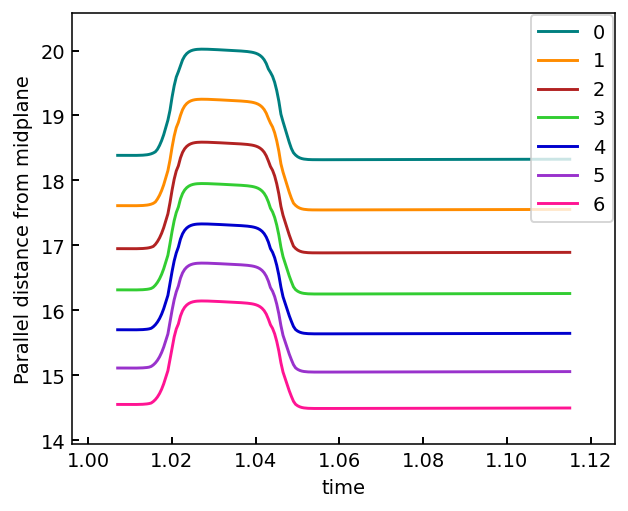

In [47]:
fig, ax = plt.subplots()

for sepadd in range(7):
    ax.plot(df["t"], df[sepadd], label = sepadd)
        
ax.set_xlabel("time")
ax.set_ylabel("Parallel distance from midplane")
ax.legend()

In [42]:
df[0]

0      18.386591
1      18.386379
2      18.386196
3      18.386018
4      18.385856
         ...    
212    18.327039
213    18.327095
214    18.327150
215    18.327205
216    18.327259
Name: 0, Length: 217, dtype: float64

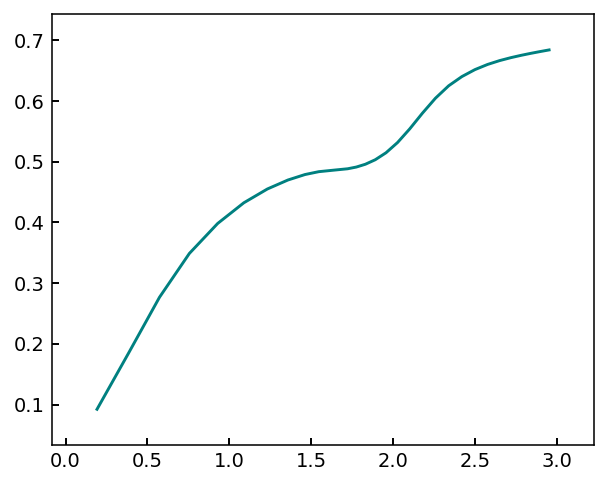

In [36]:
plt.plot(dist, pardist)

Text(0.5, 0, 't [ms]')

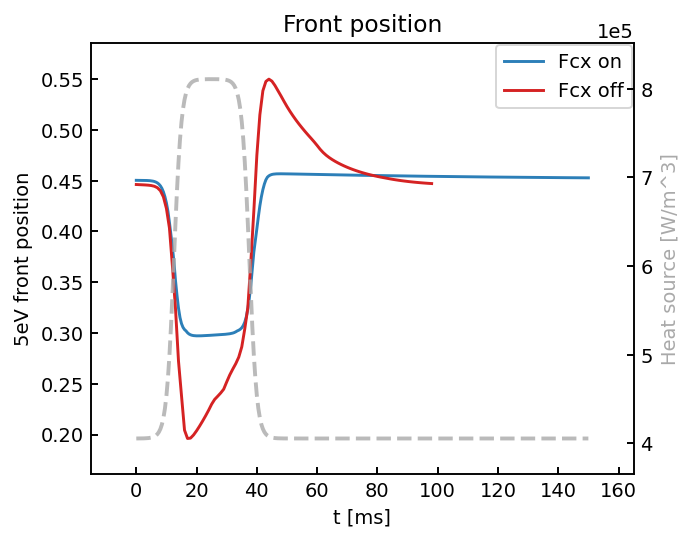

In [10]:
# ds = cs["tune_4x"].ds
plt.close("all")
%matplotlib inline

ds1 = cs["Fcx on"].ds
ds2 = cs["Fcx off"].ds

for ds in [ds1, ds2]:
    ds["heat_source"] = ((ds["Pd+_src"] + ds["Pe_src"])*ds["dv"]).sum(["x", "theta"])
    ds["t_norm"] = (ds["t"] - ds["t"][0])*1000

fig, ax = plt.subplots()

# for name in cs:
# ds = cs[name].ds
ax.plot(ds1["t_norm"], ds1["front_poldist_5eV"], label = "Fcx on", color = "#2C7FB8")
ax.plot(ds2["t_norm"], ds2["front_poldist_5eV"], label = "Fcx off", color = "#D52223")

ax2 = ax.twinx()


ax2.plot(ds1["t_norm"], ds1["heat_source"], lw = 2, ls = "--", c = "darkgrey", alpha = 0.8)
ax2.set_ylabel("Heat source [W/m^3]", color = "darkgrey")

ax.legend()
ax.set_ylabel("5eV front position")
ax.set_title("Front position")
ax.set_xlabel("t [ms]")